#### Hypothesis: Masks have been an extremely controversial topic during the pandemic. Though a majority of people agree they are beneficial, there are a few who disagree with the effectiveness of masks. I want to see if masks are associated with a positive sentiment or negative sentiment. If they are associated with a positive sentiment, it means it is likely to be a beneficial piece of equipment and it should be worn when people are interacting with each other. If there is a negative sentiment it shows that it may potentially not be helpful. I am also interested to see the sentiment before COVID-19 and during COVID-19. As these are research articles, my hypothesis would be masks are beneficial and the sentiment is very similar. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Conv1D, MaxPool1D,GlobalMaxPooling1D,Input, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers.merge import Concatenate
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical,plot_model
from numpy import array
from numpy import asarray
from numpy import zeros
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import html
import unicodedata
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Exploration and Preprocessing

In [2]:
#Uploaed the required files to Google Drive and Mount the Drive

#from google.colab import drive
#drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#Read the research metadata and see the info of the data
RawData = pd.read_csv('metadata.csv')
RawData.info(verbose=True)
RawData.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [4]:
#Select potentially useful information from RawData
RawData = RawData[['title','abstract','publish_time']] #Only keep title, abstact, publish time columns
RawData = RawData.drop_duplicates(subset='abstract', keep="first") #drop any existing duplicated
RawData=RawData.dropna() #drop any NaNs
RawData["abstract"] = RawData["abstract"].str.lower() #lower all strings, this will be import when searching for a certain word
RawData.head()

,title,abstract,publish_time
0,Clinical features of culture-proven Mycoplasma...,objective: this retrospective chart review des...,2001-07-04
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases of the respiratory tract...,2000-08-15
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in th...,2000-08-25
3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,2001-02-22
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus (rsv) and pneumoni...,2001-05-11


In [5]:
#Get data for abstracts that contain the word mask 
MaskData = RawData[RawData['abstract'].str.contains("mask")]

In [6]:
MaskDataCovid19 = MaskData[MaskData['publish_time'].str.contains("2020|2021")] #Keep Data from 2020 and 2021
MaskDataPre = MaskData[~MaskData['publish_time'].str.contains("2020|2021")] #Remove All Data from 2020 and 2021

In [7]:
#Searches for text, and retrieves n words either side of the mask, which are retuned as a line
def search(text,n):
    word = r"\W*([\w]+)"
    try:
      groupss = re.search(r'{}\W*{}{}'.format(word*n,'mask',word*n), text).group()
      return groupss
    except:
      return ''

In [8]:
#Take Arrays of only abstract data which will be used in the Machine Learning. Keep publish times for to visualize the publish dates of all the data
MaskDataPreAbs = np.array(MaskDataPre['abstract']) 
MaskDataPreDates = np.array(MaskDataPre['publish_time'])
MaskDataCovid19Abs = np.array(MaskDataCovid19['abstract'])
MaskDataCovid19Dates = np.array(MaskDataCovid19['publish_time'])

In [9]:
#Create an array of all the publish data for the mask data
AllTheDates = []
for i in range(0,len(MaskDataPreDates)):
  AllTheDates.append(MaskDataPreDates[i][:4])

for i in range(0,len(MaskDataCovid19Dates)):
  AllTheDates.append(MaskDataCovid19Dates[i][:4]) 

Text(0, 0.5, 'Total number of Publications')

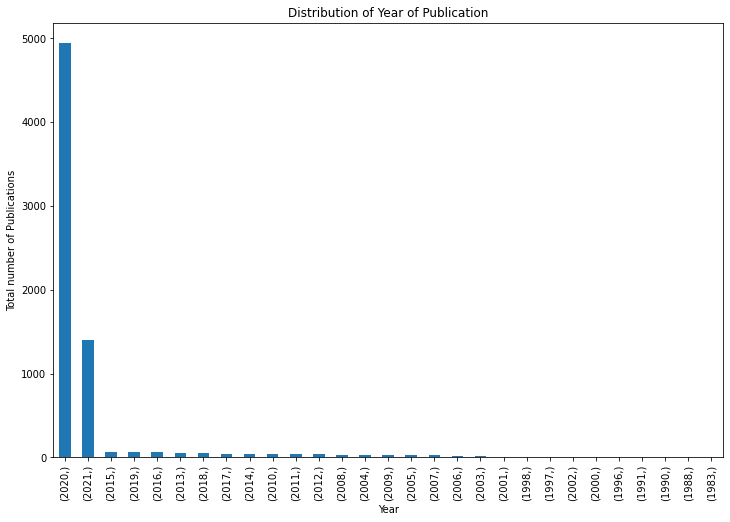

In [10]:
#Put the dates in a pandas dataframe so it can easily be ploted
AllTheDates = pd.DataFrame(data = AllTheDates)
AllTheDates.value_counts().plot(kind = 'bar',figsize=(12,8))
plt.title('Distribution of Year of Publication')
plt.xlabel('Year')
plt.ylabel('Total number of Publications')

Most of the publications were in 2020 and 2021 which is during COVID-19, a slight shock as I expected more reviews from MERS in 2012,2015,2018 and SARS in 2002-2004 but they were not worldwide pandemics

In [11]:
#Only keep 5 words before and after the word mask. My goal is to only to see the sentiment around the word mask
PreMaskWords = []
for i in range(0,len(MaskDataPreAbs)):
  sears = search(MaskDataPreAbs[i],5)
  PreMaskWords.append(sears)

Covid19MaskWords = []
for i in range(0,len(MaskDataCovid19Abs)):
  sears = search(MaskDataCovid19Abs[i],5)
  Covid19MaskWords.append(sears)

(-0.5, 1599.5, 799.5, -0.5)

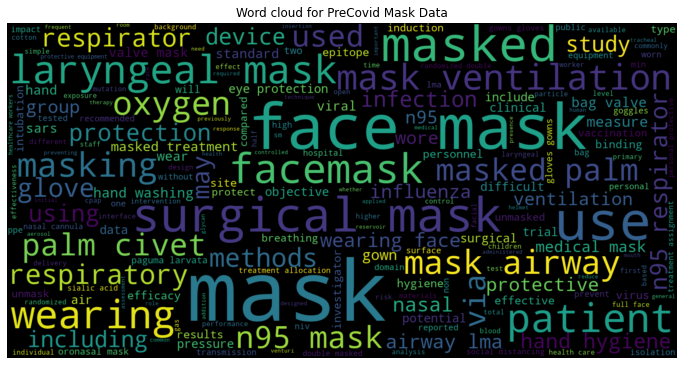

In [12]:
#Plot word cloud for pre covid mask data
PreMaskStr = []
for t in PreMaskWords:
    PreMaskStr.append(t)
PreMaskStr = pd.Series(PreMaskStr).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(PreMaskStr)
fig, axes = plt.subplots(1, 1, figsize = (12,10))
axes.set_title('Word cloud for PreCovid Mask Data')
axes.imshow(wordcloud, interpolation="bilinear")
axes.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

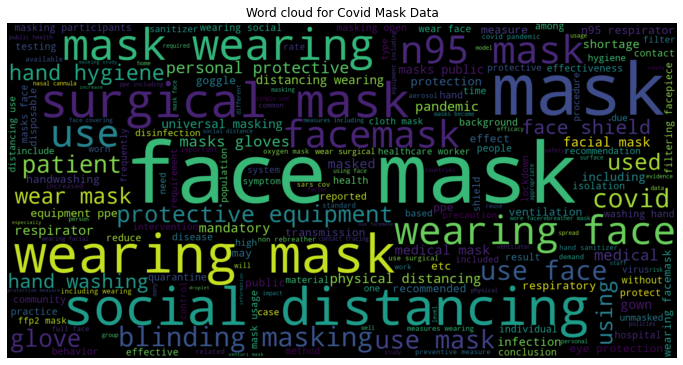

In [13]:
#Plot word cloud for during covid mask data
CovidMaskStr = []
for t in Covid19MaskWords:
    CovidMaskStr.append(t)
CovidMaskStr = pd.Series(CovidMaskStr).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(CovidMaskStr)
fig, axes = plt.subplots(1, 1, figsize = (12,10))
axes.set_title('Word cloud for Covid Mask Data')
axes.imshow(wordcloud, interpolation="bilinear")
axes.axis("off")

# Previous DataSet With Sentiment Labels

In [14]:
#Dataset used from previous project which already as sentiment labels that the ML model can be used to train on
data_train = pd.read_csv("train.csv")

In [15]:
#Data needs to be cleaned so there is only text data present
def clean_data(text):  

    text = re.sub('@\S+', '', text) 
    text = text.replace('\n','')
    #change all text to lowercase
    text = text.lower()
    
    #delete all hyperlinks and URL's
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #Convert all HTML to ASCII
    text = html.unescape(text)
    
    #Remove all tags
    text = text.translate(str.maketrans('','','/<[^>]+>/'))
    
    #Remove all stop-words
    text = (" ").join([w for w in word_tokenize(text) if not w in stop_words])
    
    #Remove the word 'rt'
    text = re.sub('rt ', '', text)
    
    #Remove all punctuations
    text = re.sub('[^A-Za-z0-9]', ' ', text)
    
    #Remove all only numerical data
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)
    
    return str(text)

In [16]:
#Clean train dataset
data_train['reviewText'] = data_train['reviewText'].map(str)
data_train['reviewText'] = data_train['reviewText'].apply(lambda x: clean_data(x))

In [17]:
#Split Data for Training
y = data_train['overall'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_train['reviewText'], y, test_size=0.20, random_state=42)

In [18]:
#Word tokenizer from Keras is used to one hot encode words in a review
#It assigns an index to different words that can be used to then vectorize it using word embeddings
#The tokenizer looks at all the text data and keeps the most frequent 6000 words however all the words are stored in the vocabolary

tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X_train2)

X_train = tokenizer.texts_to_sequences(X_train2)
X_test = tokenizer.texts_to_sequences(X_test2)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

In [19]:
#Creates an embedding dictionary using the glove word embedding 
#Then loops through each word and vectorizes based on 100 features, these features have values which help determine how similar words are
# The glove data can be downloaded at http://nlp.stanford.edu/data/glove.6B.zip , this can be extracted for the txt data
embeddings_dictionary = dict()

glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Model Development

In [20]:
#Develop model which works for both training text data and the research data
deep_inputs = Input(shape=(maxlen,))
genre_inputs = Input(shape=(5,))
price_inputs = Input(shape=(1,))

x = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
x = Conv1D(filters=16,kernel_size=3,padding='same',activation='relu')(x)
x = MaxPool1D(pool_size=2)(x)
x = Dropout(rate=0.5)(x)
x = LSTM(64)(x)

output_layer = Dense(1, activation='linear')(x)

model = Model(inputs=[deep_inputs], outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(x = [X_train],y= y_train2, batch_size=64, epochs=10, verbose=1, validation_data=(X_test,y_test2))

Epoch 1/10
1875/1875 [==============================] - 35s 9ms/step - loss: 1.5327 - mse: 1.5327 - val_loss: 0.7113 - val_mse: 0.7113
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.7293 - mse: 0.7293 - val_loss: 0.6688 - val_mse: 0.6688
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6939 - mse: 0.6939 - val_loss: 0.6621 - val_mse: 0.6621
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6834 - mse: 0.6834 - val_loss: 0.6392 - val_mse: 0.6392
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6670 - mse: 0.6670 - val_loss: 0.6392 - val_mse: 0.6392
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6705 - mse: 0.6705 - val_loss: 0.6345 - val_mse: 0.6345
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6535 - mse: 0.6535 - val_loss: 0.6595 - val_mse: 0.6595
Epoch 8/10
1875/1875 [==============================] -

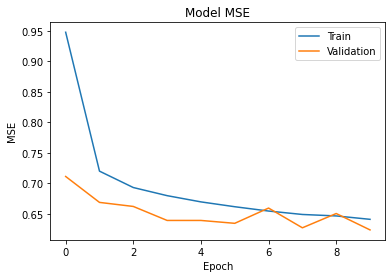

In [21]:
#Summarize history of mse for the model training
plt.plot(history.history['mse'],label="Train")
plt.plot(history.history['val_mse'],label="Validation")
plt.title("Model MSE")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()

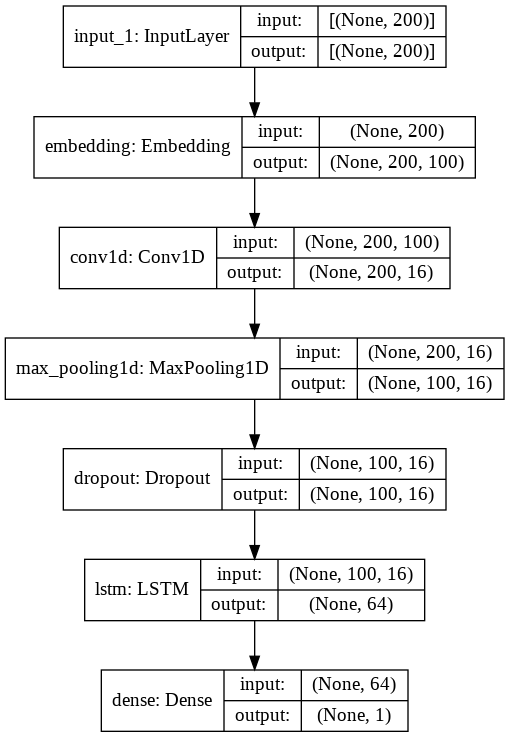

In [22]:
#Plot NN model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

## Predicting on The Medical Data

In [23]:
#Tokenize the pre covid mask data and then predict on the data. if the rating is 3 or under, it is considered a negative review. I used 3 as the data is slightly bias towards positive reviews. 
PreCovidData = tokenizer.texts_to_sequences(PreMaskWords)
PreCovidData = pad_sequences(PreCovidData, padding='pre', maxlen=maxlen)
PreCovidDataResults = model.predict(PreCovidData).round()
PreCovidDataResults[PreCovidDataResults <= 3 ] = 0
PreCovidDataResults[PreCovidDataResults > 3 ] = 1

In [24]:
#Tokenize the during covid mask data and then predict on the data. if the rating is 3 or under, it is considered a negative review. 
CovidData = tokenizer.texts_to_sequences(Covid19MaskWords)
CovidData = pad_sequences(CovidData, padding='pre', maxlen=maxlen)
CovidDataResults = model.predict(CovidData).round()
CovidDataResults[CovidDataResults <= 3 ] = 0
CovidDataResults[CovidDataResults > 3 ] = 1

Text(0, 0.5, 'Total number of Statements')

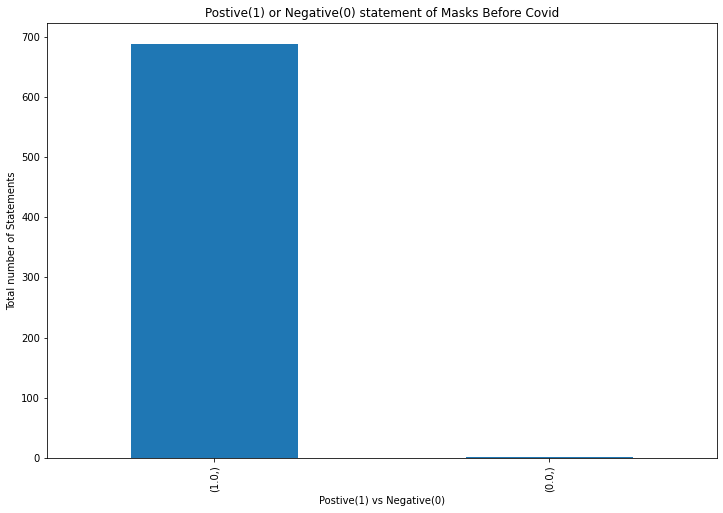

In [25]:
#Visualize the pre covid predictions 
PreCovidDataResults = pd.DataFrame(data=PreCovidDataResults)
PreCovidDataResults.value_counts().plot(kind = 'bar',figsize=(12,8))
plt.title('Postive(1) or Negative(0) statement of Masks Before Covid')
plt.xlabel('Postive(1) vs Negative(0)')
plt.ylabel('Total number of Statements')

In [26]:
#Visualize the pre covid predictions normalized so it can be compared to during covid results
PreCovidDataResults = pd.DataFrame(data=PreCovidDataResults)
PreCovidDataResults.value_counts(normalize=True)


1.0    0.997101
0.0    0.002899
dtype: float64

Text(0, 0.5, 'Total number of Statements')

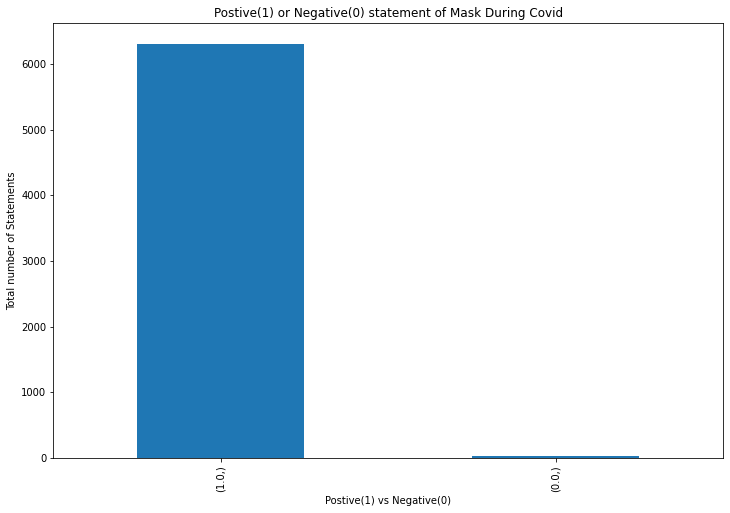

In [27]:
#Visualize the pre covid predictions 
CovidDataResults = pd.DataFrame(data=CovidDataResults)
CovidDataResults.value_counts().plot(kind = 'bar',figsize=(12,8))
plt.title('Postive(1) or Negative(0) statement of Mask During Covid')
plt.xlabel('Postive(1) vs Negative(0)')
plt.ylabel('Total number of Statements')

In [28]:
#Visualize the pre covid predictions normalized so it can be compared to during covid results
CovidDataResults = pd.DataFrame(data=CovidDataResults)
CovidDataResults.value_counts(normalize=True)

1.0    0.995893
0.0    0.004107
dtype: float64

It can be seen in the results, majority of the sentiment is positive. Masks should be worn. There is no difference in distribution pre-COVID vs during COVID, which is expected as they are research papers. For during covid 96% of the data was postive sentiment and same number for pre-Covid. Using this data, it can be said that masks are very useful and should be worn with the pandemic raging on especially during interactions with other people which is when the disease can spread.